<a href="https://colab.research.google.com/github/zhiquanlao/Qiskit-and-Cirq-Learning-Project/blob/main/Google_Tensorflow_QML_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

From https://www.tensorflow.org/quantum/overview?



In [ ]:
!pip install --quiet tensorflow==2.15.0 ipywidgets
!pip install --quiet tensorflow-quantum==0.7.3 ipywidgets

import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 67.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorstore 0.1.66 requires ml-dtypes>=0.3.1, but you have ml-dtypes 0.2.0 which is incompatible.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 81.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 56.5 MB/s eta 0:00:0

In [ ]:


a,b = sympy.symbols("a b")
q0,q1=cirq.GridQubit.rect(1,2)

qc=cirq.Circuit(cirq.rx(a).on(q0),cirq.ry(b).on(q1),cirq.CNOT(q0, q1))
SVGCircuit(qc)

z0=cirq.Z(q0)

In [ ]:
circuit_tensor=tfq.convert_to_tensor([qc])
print(circuit_tensor.shape)
print(circuit_tensor.dtype)

(1,)
<dtype: 'string'>


In [ ]:
batch_vals = np.array(np.random.uniform(0, 2 * np.pi, (5, 2)), dtype=float)
print(batch_vals)

result=[]
for val in batch_vals:
  resolver=cirq.ParamResolver({a:val[0],b:val[1]})
  final_vector=cirq.Simulator().simulate(qc,resolver).final_state_vector
  result.append([z0.expectation_from_state_vector(final_vector,{q0:0,q1:1}).real])

print(result)


#Simplify the above code by tfq:
tfq.layers.Expectation()(qc,symbol_names=[a,b],symbol_values=batch_vals,operators=z0)

[[3.31765063 0.92947072]
 [3.32283192 2.14480185]
 [1.17551126 3.12067274]
 [2.91487312 0.05750527]
 [5.96602547 4.72381278]]
[[-0.9845418334007263], [-0.9836211204528809], [0.3850712180137634], [-0.9744089841842651], [0.9501249194145203]]


<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[-0.9845416 ],
       [-0.98362094],
       [ 0.3850708 ],
       [-0.9744093 ],
       [ 0.9501256 ]], dtype=float32)>

Using a classical neural network to control a quantum circuit

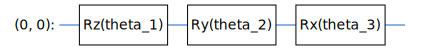

In [ ]:
#parameterized quantum circuit

#neural network will determine these parameters
control_params=sympy.symbols('theta_1 theta_2 theta_3')

qubit=cirq.GridQubit(0,0)
qc=cirq.Circuit(
  cirq.rz(control_params[0]).on(qubit),
  cirq.ry(control_params[1]).on(qubit),
  cirq.rx(control_params[2]).on(qubit)
)

SVGCircuit(qc)

#neural network
controller=tf.keras.Sequential([
  tf.keras.layers.Dense(10,activation='elu'),
  tf.keras.layers.Dense(3)
])

#